In [122]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer


from collections import Counter
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

##### Functions regarding reading in and processing individual tables of data

In [2]:
def readin_data(data_type: str):
    """ This function reads in test or train data, which must be in folders 'testing_data' and 'training_data' in the same directory.

    Parameters
    ----------
    'data_type' : str
        This must be 'test' or 'train'.
    """
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'
    if data_type == 'test':
        inner_directory = './testing_data/'
        data_list = os.listdir('./testing_data')
    else:
        inner_directory = './training_data/'
        data_list = os.listdir('./training_data')
    data_dict = {}
    for file_name in data_list:
        data_dict[file_name.split('.')[0]] = pd.read_csv(inner_directory+file_name).drop_duplicates()
    return data_dict

In [3]:
def processed_data_directory():
    """ Makes 'processed_data' directory if one is not found.

    Parameters
    ----------
    None
    """
    # Add flag for this function
    os.makedirs('./processed_data', exist_ok=True)
    return None

In [4]:
def add_uids(data_dictionary: dict):
    """ This function adds a UID to each row to establish unique instances between person_id & measurement datetimes for the various tables.
    
    This is not done for the demographics file since the information in it is not sensitive to the hour.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * UID is a concatenation of datetime and person_id, in that order.
    * UID is later used as a key for table joins.
    """
    print("Adding UIDs.")

    for table_ind in list(data_dictionary.keys()):
        if not table_ind.startswith("person_demographics"):
            table = data_dictionary[table_ind]
            datetime_index = np.argmax([i.find('datetime') for i in table.columns])
            date_column = table.columns[datetime_index]
            personid_index = np.argmax([i.find('person_id') for i in table.columns])
            personid_column = table.columns[personid_index]
            table['uid'] = table[date_column].astype(str) + table[personid_column].astype(str)
            table.drop(columns=[date_column,personid_column],inplace=True)
            data_dictionary[table_ind] = table
            # print(f'file {table_ind} with len {len(table)}')
    
    print("UIDs added")
    return None

In [5]:
def birthday_management(data_dictionary: dict):
    """
    This function processes the 'person_demographics' table of given data, which is inputed as a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * adds new birthday and visit start date columns with dates formated using datetime package.
    * joins new columns to old table using left join to match the unprocessed to the processed date
    """
    demographics_ind_no = np.argmax([table.startswith("person_demographics") for table in data_dictionary.keys()])
    demographics_index = list(data_dictionary.keys())[demographics_ind_no]
    demographics = data_dictionary[demographics_index]
    print(f"Beginning processing for {demographics_index}.")
    

    new_birthday_col = pd.DataFrame(columns=['birthday_formatted', 'person_id'])
    new_visit_col = pd.DataFrame(columns=['visit_start_date','new_visit_startdate'])
    
    for person in np.unique(demographics['person_id']):
        birthday = demographics[demographics['person_id']==person]['birth_datetime'].to_list()[0]
        birthday_formatted = datetime.strptime(birthday,'%Y-%m-%d')
        new_birthday_col.loc[len(new_birthday_col)] = [birthday_formatted, person]

    for date in np.unique(demographics['visit_start_date']):
        visit_start = demographics[demographics['visit_start_date']==date]['visit_start_date'].to_list()[0]
        new_visit_startdate = datetime.strptime(visit_start,'%Y-%m-%d')
        # print(f'new {new_visit_startdate} old {date}')
        new_visit_col.loc[len(new_visit_col)] = [date, new_visit_startdate]


    demographics = pd.merge(left=demographics,right=new_birthday_col,how='left',on='person_id')
    demographics = pd.merge(left=demographics,right=new_visit_col,how='left',on='visit_start_date')
    demographics.drop(columns=['visit_start_date','birth_datetime'],inplace=True)
    demographics.to_csv(f'./processed_data/processed_{demographics_index}.csv')
    data_dictionary[demographics_index] = demographics
    print(f"Finished processing of {demographics_index}.")
    return None

In [6]:
def measurement_meds_processing(data_dictionary: dict):
    """ This function processes the 'measurement_meds' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Details
    -------
    * removes body temperature measurements > 46 C
    """
    body_measurements_ind = np.argmax([table.startswith("measurement_meds") for table in data_dictionary.keys()])
    body_measurements_index = list(data_dictionary.keys())[body_measurements_ind]
    measurements = data_dictionary[body_measurements_index]
    print(f"Beginning processing for {body_measurements_index}.")

    
    measurements = measurements.dropna(subset=measurements.select_dtypes(float).columns, how='all')
    # measurements.drop(index=[i for i in measurements[measurements['Body temperature']>45].index], axis=1,inplace=True)
    measurements['Body temperature'] = measurements['Body temperature'].apply(lambda x: np.nan if x > 46 else x)
    measurements.to_csv(f'./processed_data/processed_{body_measurements_index}.csv')
    data_dictionary[body_measurements_index] = measurements
    print(f"Finished processing of {body_measurements_index}.")
    return None

In [189]:
def drugs_exposure_processing(data_dictionary: dict):
    """ This function processes the 'drugsexposure' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.

    Details
    -------
    * combines rows of the same datetime with different drugs to be one row per datetime with all drugs listed in new 'drugs' column and all drug routes listed in new 'routes' column
    * converts from list to string for new columns to allow categorical encoding later on
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'
    drugs_exposure_ind = np.argmax([table.startswith("drugsexposure") for table in data_dictionary.keys()])
    drugs_exposure_index = list(data_dictionary.keys())[drugs_exposure_ind]
    drugs_exposure = data_dictionary[drugs_exposure_index]
    drugs_exposure.reset_index(inplace = True, drop = True)
    print(f"Beginning processing for {drugs_exposure_index}.")

    drugs_exposure = pd.get_dummies(drugs_exposure, columns = ['drug_concept_id', 'route_concept_id'], drop_first = True, prefix="", prefix_sep="", dtype=float)
    # drugs_exposure_processed = pd.DataFrame(columns = ['uid', 'drugs', 'routes', 'visit_occurrence_id'])
    
    # for x in tqdm(np.unique(drugs_exposure['uid'])):
    #     drugs = drugs_exposure[drugs_exposure['uid']==x]['drug_concept_id'].to_list()
    #     drugs.sort()
    #     try:
    #         route = drugs_exposure[drugs_exposure['uid']==x]['route_concept_id'].to_list()
    #         route = list(set(route))
    #         route = [str(i) for i in route]
    #         route.sort()
    #     except:
    #         route = drugs_exposure[drugs_exposure['uid']==x]['route_concept_id'].to_list()
    #         route = list(set(route))
    #     visit_occurrence = drugs_exposure[drugs_exposure['uid']==x]['visit_occurrence_id'].to_list()[0]
    #     drugs_exposure_processed.loc[len(drugs_exposure_processed)]= [x,drugs,route, visit_occurrence]
    # # switching format from list to string for later processing of categorical data:
    # for row in drugs_exposure_processed['drugs']:
    #     row = str(row)[1:-1]
    # for row in drugs_exposure_processed['routes']:
    #     row = str(row)[1:-1]


    # drugs_exposure_processed['drugs'] = drugs_exposure_processed['drugs'].apply(lambda x: str(x)[1:-1])
    # drugs_exposure_processed['drugs'] = drugs_exposure_processed['drugs'].apply(lambda x: np.nan if x=='a' else x)
    # drugs_exposure_processed['routes'] = drugs_exposure_processed['routes'].apply(lambda x: np.nan if x is str else str(x)[1:-1])
    # drugs_exposure_processed['routes'] = drugs_exposure_processed['routes'].apply(lambda x: np.nan if x=='a' else x)

    # data_dictionary[drugs_exposure_index] = drugs_exposure_processed


    drugs_count = pd.DataFrame([list(i) for i in Counter(drugs_exposure['uid']).items()],columns=['uid','count'])
    drugs_count['count'].astype(int)
    drugs_rows = []
    drugs_extras = drugs_count[drugs_count['count']>1]
    for j in tqdm([i for i in drugs_extras['uid']]):
        new_row = drugs_exposure[drugs_exposure['uid']==j].max().to_frame().T.values.tolist()
        drugs_rows.extend(new_row)
        # drugs_rows = pd.concat([drugs_rows,drugs_exposure[drugs_exposure['uid']==j].max().to_frame().T]).reset_index(drop=True)
    # drugs_extras_ind = drugs_extras.index
    # print(f'first len {len(drugs_exposure)}')
    drugs_exposure.drop_duplicates(subset='uid', keep = False, inplace=True)
    # drugs_exposure = drugs_exposure.drop(index=drugs_extras_ind, axis=1,inplace=False)
    # print(f'after len {len(drugs_exposure)}')
    drugs_rows_df = pd.DataFrame(drugs_rows, columns = drugs_exposure.columns)
    drugs_exposure = pd.concat([drugs_exposure,drugs_rows_df]).reset_index(drop=True)
    data_dictionary[drugs_exposure_index] = drugs_exposure
    drugs_exposure.to_csv(f'./processed_data/processed_{drugs_exposure_index}.csv')
    print(f"Finished processing of {drugs_exposure_index}.")
    return None

In [205]:
def measurement_lab_processing(data_dictionary: dict):
    """ This function processes the 'measurement_lab' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.

    Details
    -------
    * removes rows which are all NA
    * combines rows which have the same datetime but different columns filled (different columns have non-NA values)
    * converts columns to float to resolve typing issue
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'

    measurement_lab_ind = np.argmax([table.startswith("measurement_lab") for table in data_dictionary.keys()])
    measurement_lab_index = list(data_dictionary.keys())[measurement_lab_ind]
    measurement_lab = data_dictionary[measurement_lab_index]
    print(f"Beginning processing for {measurement_lab_index}.")

    nan_col_inds = list(measurement_lab.isna().all())
    nan_col_indices = list(measurement_lab.loc[:,nan_col_inds].columns)
    measurement_lab.drop(columns=nan_col_indices, inplace=True)

    measurement_lab = measurement_lab.dropna(subset=list(measurement_lab.select_dtypes(float).columns), how='all')
    measurement_lab_count = pd.DataFrame([list(i) for i in Counter(measurement_lab['uid']).items()],columns=['uid','count'])
    measurement_lab_count['count'].astype(int)
    measurement_lab_rows = pd.DataFrame()
    measurement_lab_extras = measurement_lab_count[measurement_lab_count['count']>1]
    for j in [i for i in measurement_lab_extras['uid']]:
        measurement_lab_rows = pd.concat([measurement_lab_rows,measurement_lab[measurement_lab['uid']==j].max().to_frame().T]).reset_index(drop=True)
    # measurement_lab_extras_ind = measurement_lab_extras.index
    # measurement_lab = measurement_lab.drop(index=measurement_lab_extras_ind, axis=1,inplace=False)
    measurement_lab.drop_duplicates(subset='uid', keep = False, inplace=True)

    
    measurement_lab = pd.concat([measurement_lab,measurement_lab_rows]).reset_index(drop=True)

    col_inds = [not((i.endswith('_id')) or (i=='uid')) for i in list(measurement_lab.columns)]
    col_names = measurement_lab.columns.values[col_inds]
    for column in col_names:
        measurement_lab[column] = measurement_lab[column].astype(float)

    measurement_lab.to_csv(f'./processed_data/processed_{measurement_lab_index}.csv')
    data_dictionary[measurement_lab_index] = measurement_lab
    print(f"Finished processing of {measurement_lab_index}.")
    return None

In [9]:
def measurement_observation_processing(data_dictionary: dict):
    """ This function processes the 'measurement_observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    measurement_obs_ind = np.argmax([table.startswith("measurement_observation") for table in data_dictionary.keys()])
    measurement_obs_index = list(data_dictionary.keys())[measurement_obs_ind]
    measurement_obs = data_dictionary[measurement_obs_index]
    print(f"Beginning processing for {measurement_obs_index}.")

    # measurement_obs = measurement_obs.dropna(subset=measurement_obs.select_dtypes(float).columns, how='all')
    measurement_obs.to_csv(f'./processed_data/processed_{measurement_obs_index}.csv')
    data_dictionary[measurement_obs_index] = measurement_obs
    print(f"Finished processing of {measurement_obs_index}.")
    return None

In [10]:
def observation_processing(data_dictionary: dict):
    """ This function processes the 'observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    observation_ind = np.argmax([table.startswith("observation") for table in data_dictionary.keys()])
    observation_index = list(data_dictionary.keys())[observation_ind]
    observation = data_dictionary[observation_index]
    print(f"Beginning processing for {observation_index}.")


    observation = observation.dropna(subset=observation.select_dtypes(object).columns, how='all')

    observation.to_csv(f'./processed_data/processed_{observation_index}.csv')

    data_dictionary[observation_index] = observation 
    print(f"Finished processing of {observation_index}.")
    return None

In [11]:
def procedures_processing(data_dictionary: dict):
    """ This function processes the 'observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.
    
    Details
    -------
    * drops visit_occurrence column
    * drops duplicate entries
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'

    procedures_ind = np.argmax([table.startswith("proceduresoccurrences") for table in data_dictionary.keys()])
    procedures_index = list(data_dictionary.keys())[procedures_ind]
    procedures = data_dictionary[procedures_index]
    print(f"Beginning processing for {procedures_index}.")

    procedures = procedures.dropna(subset=procedures.select_dtypes(object).columns, how='all')


    visit_id_index = np.argmax([i.find('visit_occurrence') for i in procedures.columns])
    visit_column = procedures.columns[visit_id_index]
    procedures.drop(columns=visit_column,inplace=True)
    procedures.drop_duplicates(inplace=True)

    procedures.to_csv(f'./processed_data/processed_{procedures_index}.csv')


    data_dictionary[procedures_index] = procedures 
    print(f"Finished processing of {procedures_index}.")
    return None

In [196]:
def devices_processing(data_dictionary: dict):
    """ This function processes the 'devices' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    devices_ind = np.argmax([table.startswith("devices") for table in data_dictionary.keys()])
    devices_index = list(data_dictionary.keys())[devices_ind]
    devices = data_dictionary[devices_index]
    print(f"Beginning processing for {devices_index}.")

    devices = devices.dropna(subset=devices.select_dtypes(object).columns, how='all')
    devices.drop_duplicates(inplace=True)

    visit_id_index = np.argmax([i.find('visit_occurrence') for i in devices.columns])
    visit_column = devices.columns[visit_id_index]
    devices.drop(columns=visit_column,inplace=True)

    devices = pd.get_dummies(devices, columns = ['device'], drop_first = True, prefix="", prefix_sep="", dtype=float)

    devices_count = pd.DataFrame([list(i) for i in Counter(devices['uid']).items()],columns=['uid','count'])
    devices_count['count'].astype(int)
    devices_rows = []
    devices_extras = devices_count[devices_count['count']>1]
    for j in tqdm([i for i in devices_extras['uid']]):
        new_row = devices[devices['uid']==j].max().to_frame().T.values.tolist()
        devices_rows.extend(new_row)

    devices.drop_duplicates(subset='uid', keep = False, inplace=True)
    devices_rows_df = pd.DataFrame(devices_rows, columns = devices.columns)
    devices = pd.concat([devices,devices_rows_df]).reset_index(drop=True)

    devices.to_csv(f'./processed_data/processed_{devices_index}.csv')

    data_dictionary[devices_index] = devices
    print(f"Finished processing of {devices_index}.")
    return None

In [13]:
def sepsis_processing(data_dictionary: dict):
    """ This function processes the 'sepsis' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * drops values which have no datetime
    """
    sepsis_ind = np.argmax([table.startswith("SepsisLabel") for table in data_dictionary.keys()])
    sepsis_index = list(data_dictionary.keys())[sepsis_ind]
    sepsis = data_dictionary[sepsis_index]
    print(f"Beginning processing for {sepsis_index}.")

    #Taking out values that have no datetime:
    no_time_rows = list(sepsis.loc[sepsis['uid'].str.startswith('nan', na=False)].index)
    sepsis = sepsis.drop(index=no_time_rows, axis = 1, inplace = False)
    
    data_dictionary[sepsis_index] = sepsis
    sepsis.to_csv(f'./processed_data/processed_{sepsis_index}.csv')
    
    print(f"Finished processing of {sepsis_index}.")
    return None

In [14]:
def process_data(data_type: str, load_tables: str):
    """ This function reads in test or train data and goes through functions to preprocess it. For further details see specific functions.

    Processed tables will be saved into the /processed folder.

    Parameters
    ----------
    'data_type' : str
        This must be 'test' or 'train'. Determines which data to process.
    'load_tables' : str
        This must be 'yes' or 'no'. 'yes' means load csvs from processed_data folder, of the type given in 'data_type' input. 'no' means process data from training or testing folder, depending on 'data_type' input given.
    
    Returns
    -------
    'processed_data' : dict
        This is a dictionary of datatables that have been processed
    'factors' : DataFrame
        This is a DataFrame of the data from 'processed_data' joined together.
    """
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'
    assert (load_tables=='yes') or (load_tables=='no'), f'You gave load_tables as {load_tables}. Please define load_tables as "test" or "train."'

    processed_data_directory()

    if data_type == 'train':
        if load_tables == 'no':
            training_data = readin_data('train')
            add_uids(training_data)
            birthday_management(training_data)
            measurement_meds_processing(training_data)
            drugs_exposure_processing(training_data)
            measurement_lab_processing(training_data)
            procedures_processing(training_data)
            observation_processing(training_data)
            measurement_observation_processing(training_data)
            devices_processing(training_data)
            sepsis_processing(training_data)
        else:
            training_data={}
            inner_directory = './processed_data/'
            data_list = os.listdir('./processed_data')
            separator = '_'
            for file_name in data_list:
                if file_name.split('.')[0].split('_')[-1]=='train':
                    training_data[separator.join(file_name.split('.')[0].split('_')[1:])] = pd.read_csv(inner_directory+file_name,index_col=0).drop_duplicates()

        factors = pd.merge(left=training_data['measurement_meds_train'], right=training_data['measurement_lab_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['drugsexposure_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['proceduresoccurrences_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['devices_train'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=training_data['person_demographics_episode_train'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=training_data['SepsisLabel_train'],right=factors,how='left',on='uid')
        factors.to_csv(f'./processed_data/factors_train.csv')
        processed_data = training_data

    else:
        if load_tables == 'no':
            testing_data = readin_data('test')
            add_uids(testing_data)
            birthday_management(testing_data)
            measurement_meds_processing(testing_data)
            drugs_exposure_processing(testing_data)
            measurement_lab_processing(testing_data)
            procedures_processing(testing_data)
            observation_processing(testing_data)
            measurement_observation_processing(testing_data)
            devices_processing(testing_data)
            sepsis_processing(testing_data)
        else:
            training_data={}
            inner_directory = './processed_data/'
            data_list = os.listdir('./processed_data')
            separator = '_'
            for file_name in data_list:
                if file_name.split('.')[0].split('_')[-1]=='test':
                    training_data[separator.join(file_name.split('.')[0].split('_')[1:])] = pd.read_csv(inner_directory+file_name,index_col=0).drop_duplicates()
            
        factors = pd.merge(left=testing_data['measurement_meds_test'], right=testing_data['measurement_lab_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['drugsexposure_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['proceduresoccurrences_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['devices_test'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=testing_data['person_demographics_episode_test'], how='outer',on='visit_occurrence_id')
        print(f"factors length {len(factors)} and sepsis has {len(testing_data['SepsisLabel_test'])}")
        factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')
        print(f'post merge factors {len(factors)}')
        factors.to_csv(f'./processed_data/factors_test.csv')
        processed_data = testing_data

    factors.drop(columns=['visit_occurrence_id_x','visit_occurrence_id_y'],inplace=True)

    return processed_data, factors

##### Processing Data using cummulative function

In [190]:
training_data, data_factors = process_data(data_type='train', load_tables='no')

Adding UIDs.
UIDs added
Beginning processing for person_demographics_episode_train.
Finished processing of person_demographics_episode_train.
Beginning processing for measurement_meds_train.
Finished processing of measurement_meds_train.
Beginning processing for drugsexposure_train.


100%|██████████| 27594/27594 [06:32<00:00, 70.30it/s]


Finished processing of drugsexposure_train.
Beginning processing for measurement_lab_train.
Finished processing of measurement_lab_train.
Beginning processing for proceduresoccurrences_train.
Finished processing of proceduresoccurrences_train.
Beginning processing for observation_train.
Finished processing of observation_train.
Beginning processing for measurement_observation_train.
Finished processing of measurement_observation_train.
Beginning processing for devices_train.
Finished processing of devices_train.
Beginning processing for SepsisLabel_train.
Finished processing of SepsisLabel_train.


In [206]:
testing_data, test_data_factors = process_data(data_type='test', load_tables='no')

Adding UIDs.
UIDs added
Beginning processing for person_demographics_episode_test.
Finished processing of person_demographics_episode_test.
Beginning processing for measurement_meds_test.
Finished processing of measurement_meds_test.
Beginning processing for drugsexposure_test.


100%|██████████| 10995/10995 [01:16<00:00, 143.95it/s]


Finished processing of drugsexposure_test.
Beginning processing for measurement_lab_test.


C:\Users\pears\AppData\Local\Temp\ipykernel_27700\3449249741.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_lab.drop_duplicates(subset='uid', keep = False, inplace=True)


Finished processing of measurement_lab_test.
Beginning processing for proceduresoccurrences_test.
Finished processing of proceduresoccurrences_test.
Beginning processing for observation_test.
Finished processing of observation_test.
Beginning processing for measurement_observation_test.
Finished processing of measurement_observation_test.
Beginning processing for devices_test.


100%|██████████| 156/156 [00:04<00:00, 32.20it/s]


Finished processing of devices_test.
Beginning processing for SepsisLabel_test.
Finished processing of SepsisLabel_test.
factors length 430209 and sepsis has 130483
post merge factors 130483


In [46]:
trained_data, trained_factors = process_data(data_type='train', load_tables='yes')

In [140]:
def merge_data(data_directory: dict, data_type: str):
    """ This function takes a data dictionary of tables and merges to have a table of factors for categorical encoding etc.

    
    note that this function is currently untested.
    
    Parameters
    ----------
    'data_directory' : dict
        This is a data dictionary of pandas DataFrames.
    'data_type' : str
        This must be 'test' or 'train'.
    
    Returns
    -------
    'factors' : DataFrame
        This is a DataFrame of the data from 'processed_data' joined together.    
    """
    #Untested
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'

    if data_type == 'train':
        training_data = data_directory.copy()

        factors = pd.merge(left=training_data['measurement_meds_train'], right=training_data['measurement_lab_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['drugsexposure_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['proceduresoccurrences_train'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=training_data['person_demographics_episode_train'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=factors, right=training_data['devices_train'],how='outer',on='uid')
        factors = pd.merge(left=training_data['SepsisLabel_train'],right=factors,how='left',on='uid')
        factors.to_csv(f'./processed_data/processed_train_{factors}.csv')

    else:
        testing_data = data_directory.copy()

        factors = pd.merge(left=testing_data['measurement_meds_test'], right=testing_data['measurement_lab_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['drugsexposure_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['proceduresoccurrences_test'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=testing_data['person_demographics_episode_test'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=factors, right=testing_data['devices_test'],how='outer',on='uid')
        factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')

        factors.to_csv(f'./processed_data/processed_test_{factors}.csv')

    return factors

In [208]:
data_factors_2 = data_factors.copy()

In [209]:
data_factors_3 = data_factors.copy()

In [210]:
training_data_2 = training_data.copy()

In [211]:
test_data_factors_2 = test_data_factors.copy()
testing_data_2 = testing_data.copy()

In [68]:
Counter(data_factors_2['SepsisLabel'])

Counter({0: 324753, 1: 6874})

##### Functions addressing df of merged data

In [216]:
def new_person_ids(df: pd.DataFrame):
    """
    This function reads person_id column for all rows based on UID and adds a new column with this information.

    Parameters
    ----------
    'df': pandas DataFrame
        This should be a pandas DataFrame which contains a column 'uid' with universal ids, with strings with format s.t. the person_id starts at the 18th index. e.g.: '2021-07-21 12:00:00623183219'
    """
    # assert that uid column exists
    print('Beginning adding new_person_id column based on uids.')
    new_person_ids = pd.DataFrame(columns=['new_person_id','uid'])
    new_id = df['uid'].copy().apply(lambda x: x[19:])
    # new_id.apply(lambda x: int(x))
    new_id = new_id.astype(int)
    new_person_ids['new_person_id'] = new_id
    new_person_ids['uid'] = df['uid'].copy()
    # df.drop(columns=['person_id'],inplace=True)
    df['new_person_id']=new_person_ids['new_person_id']
    print('Finished adding new_person_id column based on uids.')
    return None

In [217]:
def birthday_ubiquity(df: pd.DataFrame, data_dictionary: dict):
    """
    This function adds age in months to all rows in df based on uid time and birthday. It also adds gender to all rows in df.

    Parameters
    ----------
    'df': pandas DataFrame
        This is a pandas DataFrame of patient data that contains a 'new_person_id' column from running new_person_ids function.
    'data_dictionary': dictionary
        This is a dictionary of pandas DataFrames, should have a table of 'person_demographics_episode' data. The 'person_demographics_episode' data will be used to establish birthdays and genders for patients who occur in the DataFrame given.

    Returns
    -------
    'df': pandas DataFrame
        returns df with age in months and gender for participants with entry in 'person_demographics_episode' from provided data_dictionary.

    Details
    -------
    * makes temporary dataframe 'unique_demographics_rows' of gender and birthday from 'person_demographics_episode'
    * temporarily adds birthday by joining birthday from 'unique_demographics_rows' to df with key as new_person_id
    * temporarily creates datetime column derived from uid
    * adds age in months column by time between uid date and birthday to df in new column
    * deletes birthday column from df
    * adds gender column by joining gender from 'unique_demographics_rows' to df with key as new_person_id
    """
    #assert that new_person_id column exists

    # factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')
    print('Beginning birthday ubiquity.')

    demographics_ind_no = np.argmax([table.startswith("person_demographics") for table in data_dictionary.keys()])
    demographics_index = list(data_dictionary.keys())[demographics_ind_no]
    demographics = data_dictionary[demographics_index]

    unique_demographics_rows = pd.DataFrame(columns=['new_person_id','gender','birthday'])
    for patient in np.unique(demographics['person_id']):
        birthday = list(demographics[demographics['person_id']==patient]['birthday_formatted'])[0]
        gender = list(demographics[demographics['person_id']==patient]['gender'])[0]
        unique_demographics_rows.loc[len(unique_demographics_rows)] = [patient, gender, birthday]
    df = pd.merge(left=df, right=unique_demographics_rows, how='left', on='new_person_id')
    datetime_temp = df['uid'].copy().apply(lambda x: x[:19])
    datetime_temp = pd.to_datetime(datetime_temp)
    birthday_col = df['birthday'].copy()
    age = -round((birthday_col-datetime_temp)/np.timedelta64(1,'D')/30)
    df['age'] = age
    df.drop(columns=['birthday'], inplace = True)
    print('Birthday ubiquity established.')
    return df

In [218]:
def clearing_cols(df: pd.DataFrame, threshold: int, data_type: str, col_list: list = None):
    """
    Clears columns that shouldn't be there for modeling and columns that don't meet threshold of number of values.
    
    Parameters
    ----------
    'df' : pd.DataFrame
        DataFrame of data
    'threshold' : int
        number of values needed in a column. If column doesn't have this number of entries, it will be dropped from df. Irrelevant if 'data_type' is set to 'train'.
    'data_type' : str
        'train' or 'test'.
    'col_list' : list
        This is a list of columns to clear in test data, based on most recent run of this function with training data.

    Returns
    -------
    'df' : pd.DataFrame
    'sufficiently_empty_cols' : list
    """
    # assert data_type
    print('Clearing columns.')

    if data_type == 'train':
        sufficiently_empty_cols = list(df.loc[:,df.count() < threshold].columns)
        df.drop(columns=sufficiently_empty_cols, inplace=True)
        df.drop(columns=['visit_occurrence_id','uid'], inplace=True)
    
    if data_type == 'test':
        sufficiently_empty_cols = col_list
        df.drop(columns=sufficiently_empty_cols, inplace=True)
        df.drop(columns=['visit_occurrence_id','uid'], inplace=True)

    print('Columns cleared.')

    return df, sufficiently_empty_cols

In [219]:
def fill_from_gaussian(column_value, mean: float, std: float):
    """"
    This function imputes NaN values with values sampled from a normal distribution of parameters specified.

    Parameters
    ----------
    'column_value'
        the column this is applied to
    'mean' : float
        mean of normal distribution sampled.
    'std': float
        standard deviation of normal distribution sampled.
    """
    if np.isnan(column_value) == True:
        column_value = np.round(np.random.normal(mean, std, 1)[0], 1)
    else:
        column_value = column_value
    return column_value

In [220]:
def fill_nans_gaussian(df: pd.DataFrame):
    """
    Imputes NaN values in certain columns of df provided, based on online information of typical values by age.

    Parameters
    ----------
    'df' : pd.DataFrame
        DataFrame of data.
    
    Returns
    -------
    None. df will be updated by column.
    """
    print('filling NaN values using Gaussians.')
    
    df['Body temperature'] = df['Body temperature'].apply(fill_from_gaussian, **{'mean': 36.9, 'std': .15})

    df.loc[df['age'] <= 12, 'Systolic blood pressure'] = df.loc[df['age'] <= 12, 'Systolic blood pressure'].apply(fill_from_gaussian, **{'mean': 90, 'std': 5})
    df.loc[df['age'].between(12, 60,inclusive='right'), 'Systolic blood pressure'] = df.loc[df['age'].between(12, 60,inclusive='right'), 'Systolic blood pressure'].apply(fill_from_gaussian, **{'mean': 105, 'std': 7})
    df.loc[df['age'].between(60, 120,inclusive='right'), 'Systolic blood pressure'] = df.loc[df['age'].between(60, 120,inclusive='right'), 'Systolic blood pressure'].apply(fill_from_gaussian, **{'mean': 114, 'std': 7})
    df.loc[df['age'] >120, 'Systolic blood pressure'] = df.loc[df['age'] >120, 'Systolic blood pressure'].apply(fill_from_gaussian, **{'mean': 120, 'std': 10})

    df.loc[df['age'] <= 12, 'Diastolic blood pressure'] = df.loc[df['age'] <= 12, 'Diastolic blood pressure'].apply(fill_from_gaussian, **{'mean': 49, 'std': 5})
    df.loc[df['age'].between(12, 60,inclusive='right'), 'Diastolic blood pressure'] = df.loc[df['age'].between(12, 60,inclusive='right'), 'Diastolic blood pressure'].apply(fill_from_gaussian, **{'mean': 60, 'std': 5})
    df.loc[df['age'].between(60, 120,inclusive='right'), 'Diastolic blood pressure'] = df.loc[df['age'].between(60, 120,inclusive='right'), 'Diastolic blood pressure'].apply(fill_from_gaussian, **{'mean': 70, 'std': 5})
    df.loc[df['age'] > 120, 'Diastolic blood pressure'] = df.loc[df['age'] > 120, 'Diastolic blood pressure'].apply(fill_from_gaussian, **{'mean': 75, 'std': 7})

    df.loc[df['age'] <= 2, 'Hematocrit [Volume Fraction] of Blood'] = df.loc[df['age'] <= 2, 'Hematocrit [Volume Fraction] of Blood'].apply(fill_from_gaussian, **{'mean': 42, 'std': 4})
    df.loc[df['age'].between(2, 12,inclusive='right'), 'Hematocrit [Volume Fraction] of Blood'] = df.loc[df['age'].between(2, 12,inclusive='right'), 'Hematocrit [Volume Fraction] of Blood'].apply(fill_from_gaussian, **{'mean': 35, 'std': 4})
    df.loc[df['age'].between(12, 60,inclusive='right'), 'Hematocrit [Volume Fraction] of Blood'] = df.loc[df['age'].between(12, 60,inclusive='right'), 'Hematocrit [Volume Fraction] of Blood'].apply(fill_from_gaussian, **{'mean': 37, 'std': 2})
    # > 60 Hematocrit should vary for M vs F but not implemented here
    df.loc[df['age'] > 60, 'Hematocrit [Volume Fraction] of Blood'] = df.loc[df['age'] > 60, 'Hematocrit [Volume Fraction] of Blood'].apply(fill_from_gaussian, **{'mean': 42, 'std': 2})

    # Not a good idea to impute WBC by expected values!
    # df.loc[df['age'] <= 1, 'White blood cell count'] = df.loc[df['age'] <= 1, 'White blood cell count'].apply(fill_from_gaussian, **{'mean': 12.5, 'std': 3})
    # df.loc[df['age'].between(1, 24,inclusive='right'), 'White blood cell count'] = df.loc[df['age'].between(1, 24,inclusive='right'), 'White blood cell count'].apply(fill_from_gaussian, **{'mean': 11.5, 'std': 3})
    # df.loc[df['age'].between(24, 96,inclusive='right'), 'White blood cell count'] = df.loc[df['age'].between(24, 96,inclusive='right'), 'White blood cell count'].apply(fill_from_gaussian, **{'mean': 10, 'std': 2.5})
    # df.loc[df['age'] > 96, 'White blood cell count'] = df.loc[df['age'] > 96, 'White blood cell count'].apply(fill_from_gaussian, **{'mean': 9, 'std': 2})
    print('filled NaN values using Gaussians.')
    return None

In [221]:
def categorical_encoding(df: pd.DataFrame):
    """
    Encodes categorical data, as determined by columns with object datatypes.

    Parameters
    ----------
    'df' : pd.DataFrame
        DataFrame of Data

    Returns
    -------
    None. df is updated in place.
    """
    print('Beginning categorical encoding.')
    categorical_cols = list(df.select_dtypes(object).columns)
    le_dictionary = {}
    for name in tqdm(categorical_cols):
        le = LabelEncoder()
        le.fit(df.loc[:,f'{name}'])
        new_col = le.transform(df.loc[:,f'{name}'])
        le_dictionary[name] = le
        df.drop(columns=f'{name}', inplace=True)
        df[f'encoded_{name}'] = new_col
    print('Finished categorical encoding.')
    return None

##### Post join cummulative functions

In [213]:
def post_join_processing_train(df: pd.DataFrame, data_dictionary: dict, entry_threshold: int):
    """
    This function is for training data only.

    Runs operations on dataframe that occur after the tables of patient data have been joined together into a table of factors. This is pre-split.

    Parameters
    ----------
    'df' : pd.DataFrame
        This is a DataFrame of patient data.
    'data_dictionary' : dict
        This is a dictionary of DataFrames that was presumably used to create the DataFrame df. Data from 'person_demographics_episode' will be used to populate age and gender in df.
    'entry_threshold' : int
        Columns with count of values less than this threshold will be removed. That is, non-NaN values.
    
    Details
    -------
    * runs new_person_ids
    * runs birthday_ubiquity
    * runs clearing_cols
    * runs categorical_encoding
    """
    # add flags
    
    new_person_ids(df=df)
    df = birthday_ubiquity(df = df, data_dictionary = data_dictionary)
    df, cols_cleared = clearing_cols(df=df, threshold = entry_threshold, data_type = 'train')
    fill_nans_gaussian(df)
    categorical_encoding(df)

    return df, cols_cleared

In [214]:
def post_join_processing_test(df: pd.DataFrame, data_dictionary: dict, col_list: list):
    """
    This function is for test data only. That is, data without sepsis labels.

    Runs operations on dataframe that occur after the tables of patient data have been joined together into a table of factors. This is pre-split.

    Parameters
    ----------
    'df' : pd.DataFrame
        This is a DataFrame of patient data.
    'data_dictionary' : dict
        This is a dictionary of DataFrames that was presumably used to create the DataFrame df. Data from 'person_demographics_episode' will be used to populate age and gender in df.
    'entry_threshold' : int
        Columns with count of values less than this threshold will be removed. That is, non-NaN values.
    
    Details
    -------
    * runs new_person_ids
    * runs birthday_ubiquity
    * runs clearing_cols
    * runs categorical_encoding
    """
    # add flags
    
    new_person_ids(df=df)
    df = birthday_ubiquity(df = df, data_dictionary = data_dictionary)
    # Note that threshold for clearing_cols is irrelevant if data_type is set to 'test'.
    # Columns will be cleared based on col_list to match columns cleared from training data in most recent run of post_join_processing_train.
    df, cols = clearing_cols(df=df, threshold = 10000, data_type = 'test', col_list = col_list)
    fill_nans_gaussian(df)
    categorical_encoding(df)
    # Since test does not go through later processing that train data does.
    df.drop(columns=['new_person_id'],inplace=True)

    return df

In [230]:
data_factors_3, cols = post_join_processing_train(data_factors_3,training_data_2,10000)

Beginning adding new_person_id column based on uids.
Finished adding new_person_id column based on uids.
Beginning birthday ubiquity.
Birthday ubiquity established.
Clearing columns.
Columns cleared.
filling NaN values using Gaussians.
filled NaN values using Gaussians.
Beginning categorical encoding.


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

Finished categorical encoding.


In [223]:
test_data_factors_2 = post_join_processing_test(df=test_data_factors_2,data_dictionary=testing_data,col_list=cols)

Beginning adding new_person_id column based on uids.
Finished adding new_person_id column based on uids.
Beginning birthday ubiquity.
Birthday ubiquity established.
Clearing columns.
Columns cleared.
filling NaN values using Gaussians.
filled NaN values using Gaussians.
Beginning categorical encoding.


100%|██████████| 2/2 [00:00<00:00, 12.41it/s]

Finished categorical encoding.


##### Imputation + Smote

In [260]:
def personal_imputation(df: pd.DataFrame):
    """
    kNN imputation where neighbors considered are only from the same person via person_id.

    Parameters
    ----------
    'df' : pd.DataFrame
        a DataFrame of compiled patient data.
    
    Returns
    'new_df' : pd.Dataframe
        a DataFrame with imputed data.
    """
    
    imputed_list = []
    original_order = list(df.columns)
    for person in tqdm(np.unique(df['new_person_id'])):
        minimized_df = df[df['new_person_id']==person].copy()

        null_col_ind = minimized_df.loc[:,minimized_df.count() == 0].columns
        null_cols_list = list(null_col_ind)
        impute_col_ind = minimized_df.loc[:,minimized_df.count() != 0].columns
        imputable_cols_list = list(impute_col_ind)
        null_cols = minimized_df.loc[:,null_cols_list]
        imputable_cols = minimized_df.loc[:,imputable_cols_list]

        imp = KNNImputer(n_neighbors = 2)
        imp.fit(X = imputable_cols)
        imputed_rows = list(imp.transform(X = imputable_cols))
        
        null_list = list(null_cols)
        
        null_df = pd.DataFrame(null_list, columns=null_col_ind)
        imped_df = pd.DataFrame(imputed_rows, columns=impute_col_ind)
        merged_df = pd.concat([null_df.reset_index(drop=True),imped_df.reset_index(drop=True)], axis=1)
        merged_df = merged_df[original_order]
        imputed_list.append(list(merged_df))

    new_df = pd.DataFrame(imputed_list,columns=list(df.columns))
    new_df.to_csv(f'./processed_data/factors_imputed_by_person_id.csv')
    
    return new_df

In [261]:
imputed_factors = personal_imputation(data_factors_3)

  0%|          | 0/2640 [00:00<?, ?it/s]


NameError: name 'null_list' is not defined

In [206]:
test = data_factors_3[data_factors_3['new_person_id']==3672059]
listed = list(test.loc[:,test.count() != 0].columns)
to_imp = test.loc[:,listed]

In [263]:
test = data_factors_3[data_factors_3['new_person_id']==3672059]
to_imp = test.loc[:,listed]
imp_test = KNNImputer(n_neighbors=2)
imp_test.fit(X = to_imp)
imped = imp_test.transform(X = to_imp)
dfed = pd.DataFrame(imped)

reimp_test = KNNImputer(n_neighbors=5)
reimp_test.fit(X = to_imp)
reimpted = reimp_test.transform(X = to_imp)
redfed = pd.DataFrame(reimpted)

dfed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,35.90,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
1,0.0,36.15,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
2,0.0,36.10,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
3,0.0,36.00,-3.2,4.10,8.50,36.90,111.0,138.0,37.8,108.0,...,219.0,7.37,12.30,1.230,3672059.0,85.0,817.0,27.0,0.0,0.0
4,0.0,35.80,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
5,0.0,36.15,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
6,0.0,36.00,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
7,0.0,36.10,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
8,0.0,35.90,-3.0,3.65,9.15,37.35,109.5,138.5,38.0,112.0,...,215.0,7.37,12.55,1.235,3672059.0,85.0,817.0,27.0,0.0,0.0
9,0.0,34.60,-2.8,3.20,9.80,37.80,108.0,139.0,38.2,116.0,...,211.0,7.37,12.80,1.240,3672059.0,85.0,817.0,27.0,0.0,0.0


In [ ]:
def smoter(df_X: pd.DataFrame, df_y: pd.DataFrame):
    sampling_strat = {0: 95, 1: 5}
    smote=SMOTE(sampling_strategy=sampling_strat) 
    X,y=smote.fit_resample(df_X,df_y)
    print("completed smote")
    person_id_index = np.argmax([column.startswith('new_person_id') for column in data_factors_3.columns])
    person_id = df_X.iloc[:,person_id_index].values

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2)
    for train_x_index, test_x_index in gss.split(X=X,y=y,groups=person_id):
        X_train = X[train_x_index]
        X_test = X[test_x_index]
        y_train = y[train_x_index]
        y_test = y[test_x_index]
        person_id_train = person_id[train_x_index]
        person_id_test = person_id[test_x_index]
        
    formatted_data = {}
    formatted_data['X_train'] = X_train
    formatted_data['X_test'] = X_test
    formatted_data['y_train'] = y_train
    formatted_data['y_test'] = y_test
    formatted_data['person_id_train'] = person_id_train
    formatted_data['person_id_test'] = person_id_test

    return formatted_data

##### Modeling

In [224]:
def format_for_modeling(df):

    df.reset_index()
    person_id_index = np.argmax([column.startswith('new_person_id') for column in data_factors_3.columns])
    column_list = []
    [column_list.append(i) for i in range(1,person_id_index)]
    [column_list.append(i) for i in range(person_id_index+1,len(df.columns.values))]
    X = df.iloc[:,column_list].values
    y = df.iloc[:,0].values
    person_id = df.iloc[:,person_id_index].values
    column_names = df.columns.values[column_list]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2)
    for train_x_index, test_x_index in gss.split(X=X,y=y,groups=person_id):
        X_train = X[train_x_index]
        X_test = X[test_x_index]
        y_train = y[train_x_index]
        y_test = y[test_x_index]
        person_id_train = person_id[train_x_index]
        person_id_test = person_id[test_x_index]
        
    formatted_data = {}
    formatted_data['X_train'] = X_train
    formatted_data['X_test'] = X_test
    formatted_data['y_train'] = y_train
    formatted_data['y_test'] = y_test
    formatted_data['person_id_train'] = person_id_train
    formatted_data['person_id_test'] = person_id_test

    return formatted_data, column_names

In [225]:
def forest_model(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    person_id_train = data_dictionary['person_id_train']
    person_id_test = data_dictionary['person_id_test']

    r_forest_model = RandomForestClassifier(class_weight={0:1,1:150})
    r_forest_model.fit(X_train,y_train)

    y_pred = r_forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return r_forest_model, y_pred

In [226]:
split_data_2, column_names = format_for_modeling(data_factors_3)

In [232]:
len(data_factors_3.columns)

96

Accuracy score: 0.9842104379083869
F1 score: 0.22697368421052633


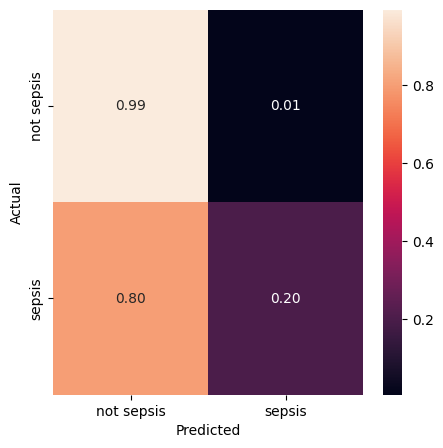

In [231]:
split_data, column_names = format_for_modeling(data_factors_3)
forest, preds = forest_model(split_data)

In [233]:
forest.feature_importances_

array([3.14543128e-02, 3.31548166e-02, 3.02539701e-02, 1.16680307e-02,
       1.03640909e-02, 1.06842391e-02, 1.86782149e-03, 4.80240915e-04,
       1.80780537e-03, 1.11952124e-03, 2.81859337e-03, 2.92751269e-02,
       1.69783846e-03, 1.89164463e-03, 2.25264033e-03, 2.53990173e-03,
       1.37714426e-03, 1.44533035e-03, 9.64589949e-04, 1.89307963e-03,
       1.05482276e-03, 2.91093856e-03, 3.64055133e-03, 2.84082343e-03,
       6.21706660e-04, 1.67363927e-03, 1.71637925e-03, 1.89878641e-03,
       2.48508666e-03, 2.21214640e-03, 2.78543006e-02, 2.70650433e-04,
       7.71529549e-09, 1.32297837e-02, 1.98199454e-02, 7.02359301e-03,
       5.31249575e-02, 6.70558262e-04, 6.73719174e-03, 2.63651007e-02,
       8.59795452e-07, 4.01967792e-02, 1.32345070e-02, 7.09152224e-05,
       6.59107638e-03, 1.33680791e-02, 2.90755556e-03, 7.31344517e-03,
       9.22625562e-03, 1.68039530e-02, 6.70213454e-03, 2.64402872e-02,
       4.13320946e-05, 1.97702202e-02, 6.60129232e-03, 3.27249256e-02,
      

In [94]:
forest.feature_importances_

array([0.03104548, 0.03111952, 0.02973935, 0.01446083, 0.01426358,
       0.0151896 , 0.00169026, 0.00053382, 0.00189842, 0.0012088 ,
       0.00267001, 0.0285367 , 0.00252177, 0.00196711, 0.00319396,
       0.00344713, 0.00153103, 0.00233059, 0.00168114, 0.00224711,
       0.00091361, 0.00334927, 0.00424034, 0.00344358, 0.00146434,
       0.0017665 , 0.00201977, 0.00228191, 0.00239886, 0.0023377 ,
       0.06334924, 0.34793486, 0.31146167, 0.02499801, 0.02675987,
       0.01000421])

In [204]:
col_compare = pd.DataFrame({'columns_1': column_names, 'columns_2': test_data_factors_2.columns})
col_compare

,columns_1,columns_2
0,Systolic blood pressure,Systolic blood pressure
1,Diastolic blood pressure,Diastolic blood pressure
2,Body temperature,Body temperature
3,Respiratory rate,Respiratory rate
4,Heart rate,Heart rate
5,Measurement of oxygen saturation at periphery,Measurement of oxygen saturation at periphery
6,Base excess in Venous blood by calculation,Base excess in Venous blood by calculation
7,Phosphate [Moles/volume] in Serum or Plasma,Phosphate [Moles/volume] in Serum or Plasma
8,Potassium [Moles/volume] in Blood,Potassium [Moles/volume] in Blood
9,Bilirubin.total [Moles/volume] in Serum or Plasma,Bilirubin.total [Moles/volume] in Serum or Plasma


In [106]:
importance = pd.DataFrame({'factors': column_names, 'importance': forest.feature_importances_}).sort_values(by='importance',ascending=False)
importance

,factors,importance
31,encoded_drugs,0.347935
32,encoded_routes,0.311462
30,age,0.063349
1,Diastolic blood pressure,0.031120
0,Systolic blood pressure,0.031045
2,Body temperature,0.029739
11,Hematocrit [Volume Fraction] of Blood,0.028537
34,encoded_device,0.026760
33,encoded_procedure,0.024998
5,Measurement of oxygen saturation at periphery,0.015190


In [235]:
def xgb_model(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    person_id_train = data_dictionary['person_id_train']
    person_id_test = data_dictionary['person_id_test']


    r_xgb_model = XGBClassifier()
    r_xgb_model.fit(X_train,y_train)

    y_pred = r_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return r_xgb_model, y_pred

Accuracy score: 0.9846807652898393
F1 score: 0.3284241531664212


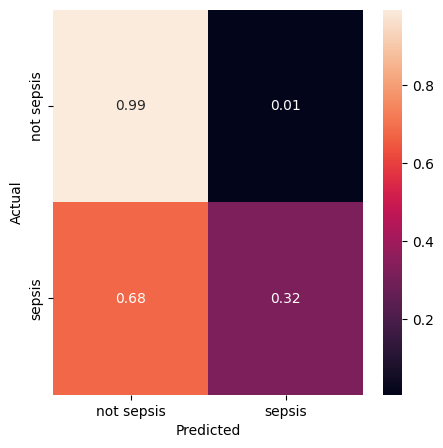

In [236]:
# split_data = format_for_modeling(data_factors_3)
xgb, preds = xgb_model(split_data)

In [238]:
prediction_submission = xgb.predict(test_data_factors_2)

ValueError: Feature shape mismatch, expected: 94, got 92

In [237]:
def make_pred_file(df: pd.DataFrame, preds: np.array):
    predictions = pd.DataFrame()
    predictions['SepsisLabel'] = prediction_submission
    person_id = df['uid'].copy().apply(lambda x: x[19:])
    datetime_val = df['uid'].copy().apply(lambda x: x[:19])
    person_id_datetime = person_id + '_' + datetime_val
    predictions['person_id_datetime'] = person_id_datetime
    return predictions

In [217]:
testpred = make_pred_file(test_data_factors_2,prediction_submission)

KeyError: 'uid'

In [215]:
testing_data['SepsisLabel_test'].sample(10)

,uid
105613,2021-09-12 15:00:001791712444
64781,2022-07-11 19:00:001378090630
59635,2023-01-11 12:00:001895560744
87144,2024-03-16 00:00:001947339187
40143,2021-08-20 17:00:00186904186
125558,2024-09-07 16:00:002086020240
72344,2021-11-26 13:00:00349497606
9281,2019-10-22 07:00:00851997392
87279,2025-01-07 15:00:001026927245
57192,2019-10-02 10:00:001357784222


In [212]:
example.sample(10)

,person_id_datetime,SepsisLabel
35116,1028596468_2024-09-11 01:00:00,0.5
106091,646733917_2023-08-06 12:00:00,0.5
103895,223961332_2023-10-21 11:00:00,0.5
99473,1913314917_2024-05-07 20:00:00,0.5
42247,1486823489_2019-09-25 16:00:00,0.5
123286,1968006557_2023-10-29 23:00:00,0.5
98747,924230729_2023-04-13 05:00:00,0.5
68647,1043583392_2024-12-06 09:00:00,0.5
125027,536768397_2023-01-14 23:00:00,0.5
101045,1827430253_2023-11-30 15:00:00,0.5


In [ ]:
xgb.predict()

##### extra

In [66]:
X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']


param_grid = { 
    'n_estimators': [100, 150, 300], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 15, 30], 
    'max_leaf_nodes': [3, 6, 9], 
} 

grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 


MemoryError: Unable to allocate 19.0 MiB for an array with shape (51979, 48) and data type float64

##### Submission

In [65]:
example = pd.read_csv('SepsisLabel_sample_submission.csv')